#  1. Spectral feature extraction

Saved Train-Calm features → (32, 1000)
Saved Train-Happy features → (32, 1000)
Saved Train-Sad features → (32, 1000)
Saved Train-Angry features → (32, 1000)
Saved Test-Calm features → (32, 1000)
Saved Test-Happy features → (32, 1000)
Saved Test-Sad features → (32, 1000)
Saved Test-Angry features → (32, 1000)


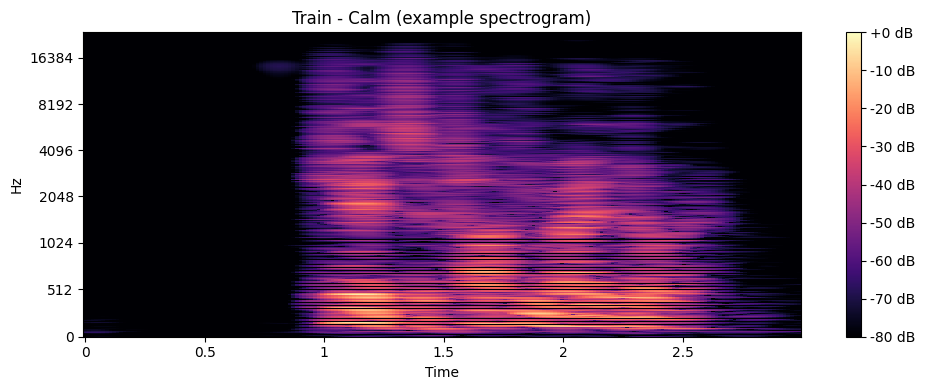

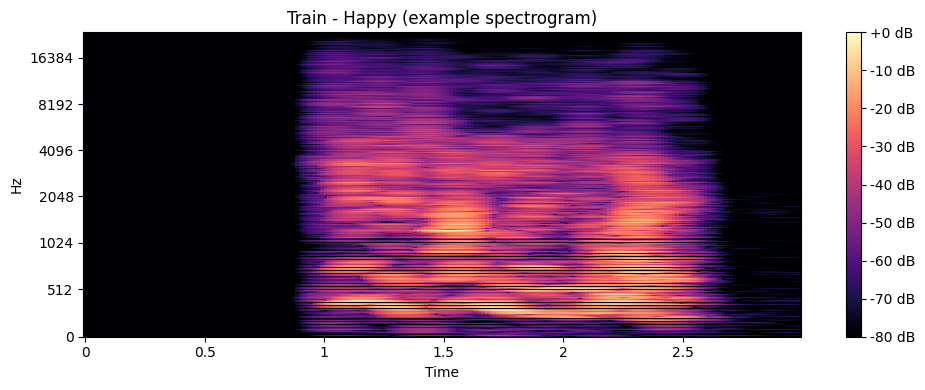

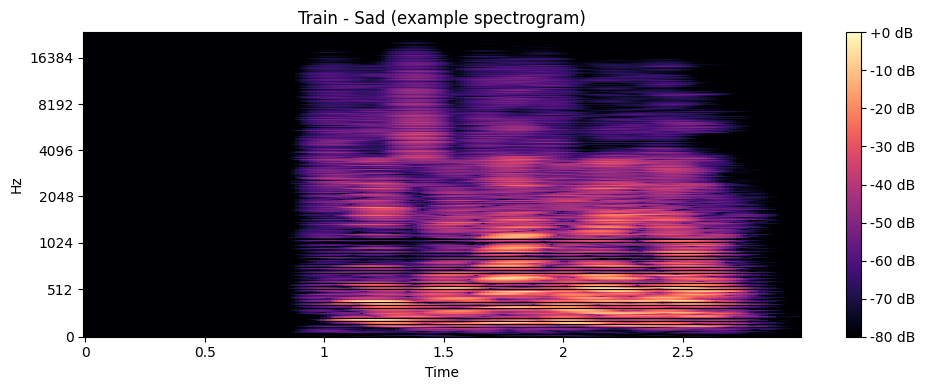

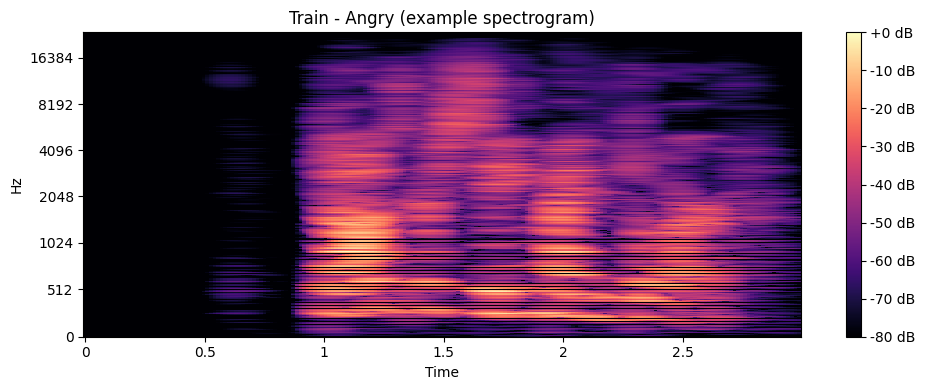

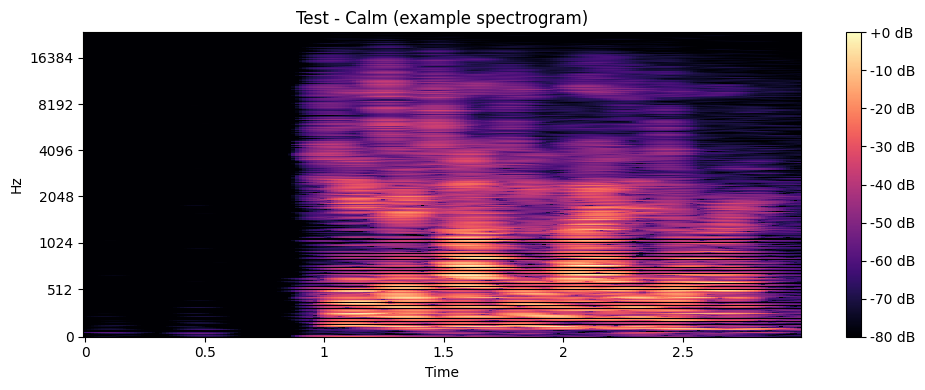

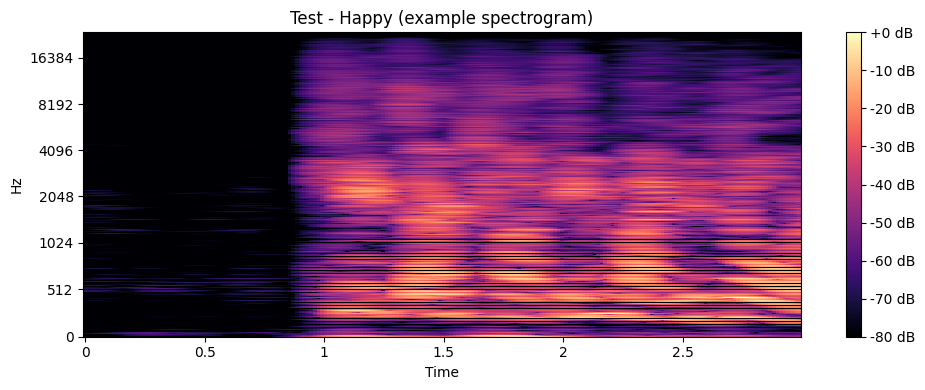

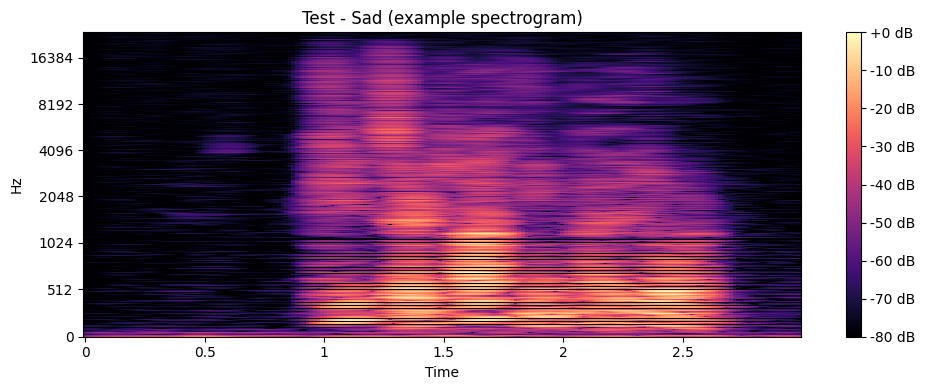

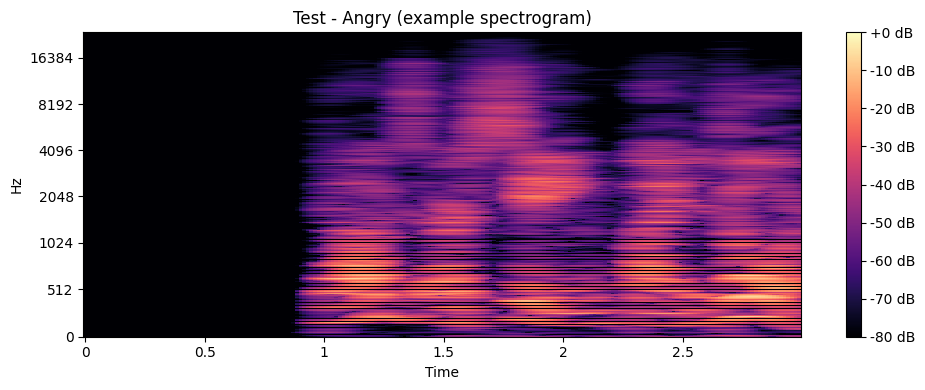

In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment

# Parameters
n_mels = 3401
n_fft = 16384
hop_duration = 0.015
num_frames = 200
power = 2.0
eps = 1e-9

# Dataset root
root = "/content/drive/MyDrive/EmotionSpeech"
emotions = ["Calm", "Happy", "Sad", "Angry"]  # consistent order
splits = ["Train", "Test"]

# Output dir for features
out_dir = "/content/drive/MyDrive/EmotionSpeech_Features"
os.makedirs(out_dir, exist_ok=True)

bands_mel = [(300, 627), (628, 1060), (1061, 1633), (1634, 2393), (2394, 3400)]

def extract_features(filename, num_frames=200):
    speech = AudioSegment.from_wav(filename)
    x = np.array(speech.get_array_of_samples(), dtype=np.float32)
    sr = speech.frame_rate

    hop_length = int(sr * hop_duration)
    S = librosa.feature.melspectrogram(
        y=x, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, power=power
    )

    # Truncate or pad to fixed frame count
    S_trunc = np.zeros((n_mels, num_frames), np.float32)
    for i in range(min(num_frames, S.shape[1])):
        S_trunc[:, i] = S[:, i]

    total_energy = np.sum(S_trunc, axis=0) + eps
    SC_all, SBW_all, SBE_all = [], [], []

    # Directly use the mel bins (no conversion)
    for (low_bin, high_bin) in bands_mel:
        sub_band = S_trunc[low_bin:high_bin+1, :]
        k = np.arange(low_bin, high_bin+1).reshape(-1, 1)
        energy = sub_band
        denom = np.sum(energy, axis=0) + eps

        sc = np.sum(k * energy, axis=0) / denom
        sbw = np.sum(((k - sc.reshape(1, -1)) ** 2) * energy, axis=0) / denom
        sbe = np.sum(energy, axis=0) / total_energy

        SC_all.append(sc)
        SBW_all.append(sbw)
        SBE_all.append(sbe)

    return np.array(SC_all).flatten(), np.array(SBW_all).flatten(), np.array(SBE_all).flatten(), S_trunc, sr, hop_length


#feature extraction and saving
for split in splits:
    for emo in emotions:
        folder = os.path.join(root, split, emo)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".wav")]
        if not files:
            continue

        SC_all, SBW_all, SBE_all = [], [], []
        labels = []
        for f in files:
            sc, sbw, sbe, *_ = extract_features(f)
            SC_all.append(sc)
            SBW_all.append(sbw)
            SBE_all.append(sbe)
            labels.append(emotions.index(emo))

        SC_all = np.array(SC_all)
        SBW_all = np.array(SBW_all)
        SBE_all = np.array(SBE_all)
        labels = np.array(labels)

        np.save(os.path.join(out_dir, f"{split}_{emo}_SC.npy"), SC_all)
        np.save(os.path.join(out_dir, f"{split}_{emo}_SBW.npy"), SBW_all)
        np.save(os.path.join(out_dir, f"{split}_{emo}_SBE.npy"), SBE_all)
        np.save(os.path.join(out_dir, f"{split}_{emo}_labels.npy"), labels)

        print(f"Saved {split}-{emo} features → {SC_all.shape}")

#  Visualisation
for split in splits:
    for emo in emotions:
        folder = os.path.join(root, split, emo)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".wav")]
        if not files:
            continue

        example_file = random.choice(files)
        _, _, _, S_trunc, sr, hop_length = extract_features(example_file)
        S_db = librosa.power_to_db(S_trunc, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                                 x_axis="time", y_axis="mel")
        plt.title(f"{split} - {emo} (example spectrogram)")
        plt.colorbar(format="%+2.0f dB")
        plt.tight_layout()
        plt.show()


# 2. Speech emotion recognition using spectral features

In [ ]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Config
feat_dir = "/content/drive/MyDrive/EmotionSpeech_Features"
emotions = ["Calm", "Happy", "Sad", "Angry"]  # keep same order as Section 1

def build_dataset(feature_type):
    X_train, y_train, X_test, y_test = [], [], [], []
    for lbl, emo in enumerate(emotions):
        Xc = np.load(os.path.join(feat_dir, f"Train_{emo}_{feature_type}.npy"))
        Xt = np.load(os.path.join(feat_dir, f"Test_{emo}_{feature_type}.npy"))
        yc = np.load(os.path.join(feat_dir, f"Train_{emo}_labels.npy"))
        yt = np.load(os.path.join(feat_dir, f"Test_{emo}_labels.npy"))

        X_train.append(Xc); X_test.append(Xt)
        y_train.extend(yc); y_test.extend(yt)

    return np.vstack(X_train), np.array(y_train), np.vstack(X_test), np.array(y_test)

def run_svm(feature_type, C=10.0, kernel="rbf"):
    print(f"\n SVM on {feature_type} (C={C}, kernel={kernel}) ")
    Xtr, ytr, Xte, yte = build_dataset(feature_type)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel))
    ])
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)

    acc = np.mean(pred == yte)
    print("Overall accuracy:", acc)
    print("Confusion matrix:\n", confusion_matrix(yte, pred))
    print("Per-class report:\n", classification_report(yte, pred, target_names=emotions, digits=4))
    return acc

# Run for SC, SBW, SBE
results = {}
for ft in ["SC", "SBW", "SBE"]:
    results[ft] = run_svm(ft, C=10.0, kernel="rbf")

print("\nSummary:")
for ft, acc in results.items():
    print(f"{ft}: {acc:.4f}")



 SVM on SC (C=10.0, kernel=rbf) 
Overall accuracy: 0.515625
Confusion matrix:
 [[26  6  0  0]
 [ 6 14  0 12]
 [ 5 16  7  4]
 [ 3  7  3 19]]
Per-class report:
               precision    recall  f1-score   support

        Calm     0.6500    0.8125    0.7222        32
       Happy     0.3256    0.4375    0.3733        32
         Sad     0.7000    0.2188    0.3333        32
       Angry     0.5429    0.5938    0.5672        32

    accuracy                         0.5156       128
   macro avg     0.5546    0.5156    0.4990       128
weighted avg     0.5546    0.5156    0.4990       128


 SVM on SBW (C=10.0, kernel=rbf) 
Overall accuracy: 0.4765625
Confusion matrix:
 [[15 11  2  4]
 [ 5 15  7  5]
 [ 3  8 14  7]
 [ 2 10  3 17]]
Per-class report:
               precision    recall  f1-score   support

        Calm     0.6000    0.4688    0.5263        32
       Happy     0.3409    0.4688    0.3947        32
         Sad     0.5385    0.4375    0.4828        32
       Angry     0.5152   

# 3. Speech emotion recognition using deep learning

## 3.1 1D CNN
### without augmentation

Epoch 0/120, Train Loss: 1.4903, Val Loss: 1.3843, Val Acc: 0.2188
Epoch 10/120, Train Loss: 1.2273, Val Loss: 1.2335, Val Acc: 0.4062
Epoch 20/120, Train Loss: 0.9804, Val Loss: 1.2029, Val Acc: 0.4375
Epoch 30/120, Train Loss: 0.8980, Val Loss: 1.1004, Val Acc: 0.5312
Epoch 40/120, Train Loss: 0.8362, Val Loss: 1.0634, Val Acc: 0.6250
Epoch 50/120, Train Loss: 0.7101, Val Loss: 1.1430, Val Acc: 0.5781
Epoch 60/120, Train Loss: 0.6746, Val Loss: 1.1531, Val Acc: 0.5781
Epoch 70/120, Train Loss: 0.6556, Val Loss: 1.1091, Val Acc: 0.6094
Epoch 80/120, Train Loss: 0.5785, Val Loss: 1.0726, Val Acc: 0.6094
Early stopping at epoch 89 (val loss not improving)
Best validation loss: 1.0292


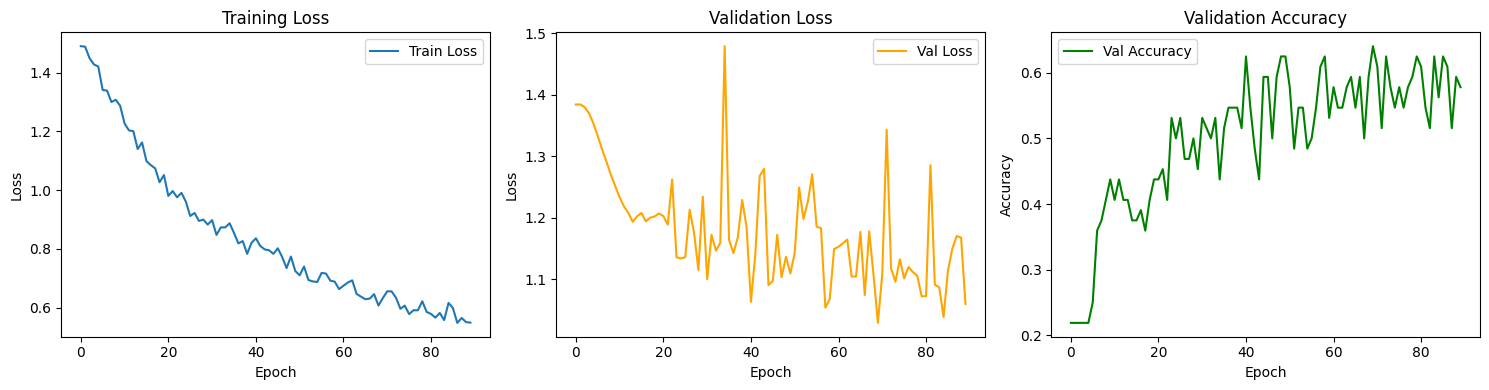


Final Test Results
Accuracy: 0.6250

Confusion Matrix:
[[15  2  0  2]
 [ 0 15  0  3]
 [ 4  2  7  3]
 [ 2  5  1  3]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.7143    0.7895    0.7500        19
        Calm     0.6250    0.8333    0.7143        18
       Happy     0.8750    0.4375    0.5833        16
         Sad     0.2727    0.2727    0.2727        11

    accuracy                         0.6250        64
   macro avg     0.6218    0.5833    0.5801        64
weighted avg     0.6535    0.6250    0.6163        64



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import random

# Fix random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Custom Dataset
class EmotionSpeechDataset(Dataset):
    def __init__(self, dataset_dir, n_frames=200, hop_length_in_sec=0.015):
        self.emotions = sorted(os.listdir(dataset_dir))  # ['Angry', 'Calm', 'Happy', 'Sad']
        self.paths = [os.path.join(dataset_dir, e, p)
                     for e in self.emotions for p in os.listdir(os.path.join(dataset_dir, e))]
        self.lengths = [len(os.listdir(os.path.join(dataset_dir, e)))
                       for e in self.emotions]
        self.n_frames = n_frames
        self.hop_length_in_sec = hop_length_in_sec

    def index2label(self, index):
        num = 0
        for i in range(len(self.lengths)):
            num += self.lengths[i]
            if index < num:
                return i

    def index2signal(self, index):
        speech = AudioSegment.from_wav(self.paths[index])
        samples = np.array(speech.get_array_of_samples(), dtype=np.float32)
        sampling_rate = speech.frame_rate
        hop_length = int(sampling_rate * self.hop_length_in_sec)
        n_samples = (self.n_frames + 1) * hop_length
        signal = np.zeros(n_samples, np.float32)
        signal[:min(n_samples, len(samples))] = samples[:min(n_samples, len(samples))]

        # Normalize by mean/std of signal
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)
        return signal

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.index2label(index)
        signal = self.index2signal(index)
        return torch.tensor(signal).unsqueeze(0), label  # shape: (1, n_samples)


# 1D CNN Model
class CNN1D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=160, stride=8)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(8)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(8)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=120, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                            steps_per_epoch=len(train_loader),
                                            epochs=num_epochs, pct_start=0.3)

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float("inf")
    best_model_state, patience_counter = None, 0
    early_stop_patience = 20

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

        # Early stopping on val loss
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (val loss not improving)")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return train_losses, val_losses, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy, all_predictions, all_labels

# Main Execution
if __name__ == "__main__":
    # Datasets
    train_dataset = EmotionSpeechDataset('/content/drive/MyDrive/EmotionSpeech/Train')
    test_dataset = EmotionSpeechDataset('/content/drive/MyDrive/EmotionSpeech/Test')

    # Split test → validation + final test
    val_size = len(test_dataset) // 2
    test_size = len(test_dataset) - val_size
    val_dataset, final_test_dataset = random_split(
        test_dataset, [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                             generator=torch.Generator().manual_seed(42))
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

    # Model
    model = CNN1D(num_classes=4)

    # Train
    train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, num_epochs=120)

    # Plot curves
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label="Val Loss", color="orange")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accs, label="Val Accuracy", color="green")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final evaluation
    accuracy, predictions, true_labels = evaluate_model(model, test_loader)

    print(f"\nFinal Test Results")
    print(f"Accuracy: {accuracy:.4f}")

    emotions = ["Angry", "Calm", "Happy", "Sad"]
    cm = confusion_matrix(true_labels, predictions)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=emotions, digits=4, zero_division=0))


## 3.2 2D CNN
### generate image

/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Generated 32 spectrogram images for Train-Angry
Generated 32 spectrogram images for Train-Calm
Generated 32 spectrogram images for Train-Happy
Generated 32 spectrogram images for Train-Sad
Generated 32 spectrogram images for Test-Angry
Generated 32 spectrogram images for Test-Calm
Generated 32 spectrogram images for Test-Happy
Generated 32 spectrogram images for Test-Sad

Total images generated: 256


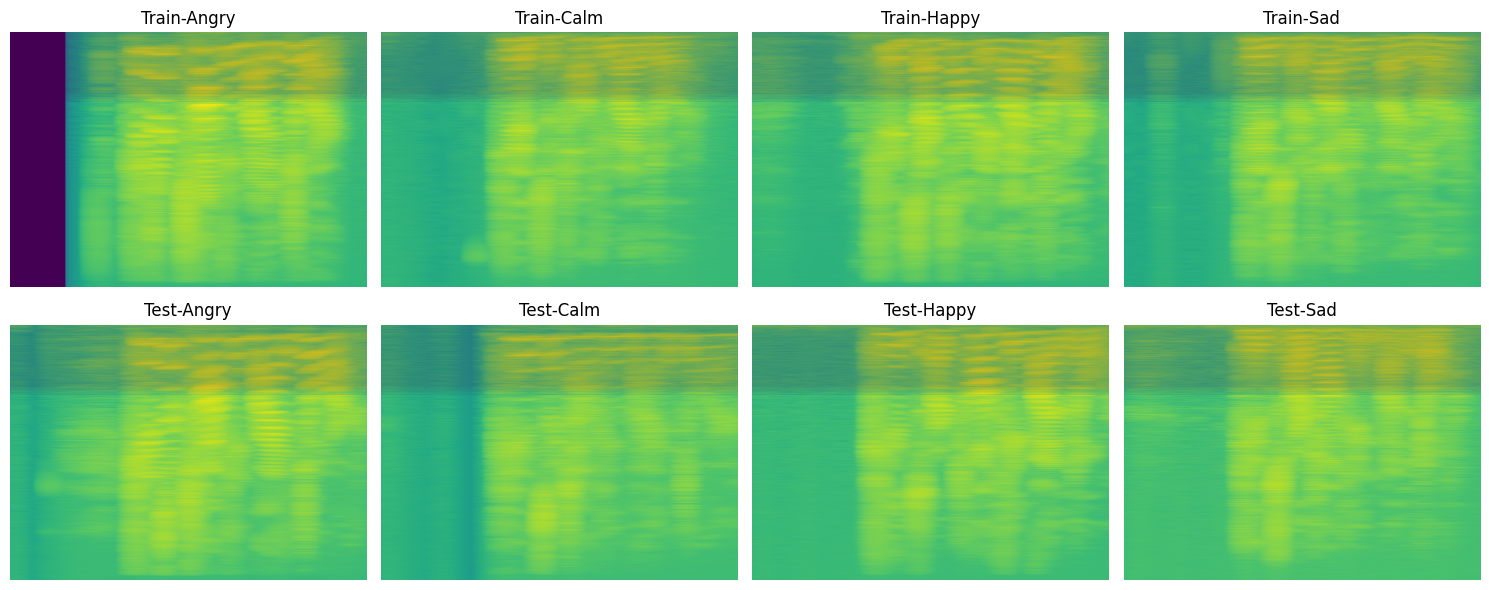


Spectrogram images saved to: /content/drive/MyDrive/EmotionSpeech_Images


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
import cv2 as cv

# Provided helper functions for saving spectrograms as images
def scale(X):
    X_min = X.min()
    X_max = X.max()
    X_scaled = (X - X_min) / (X_max - X_min) * 255
    X_scaled = X_scaled.astype(np.uint8)
    return X_scaled

def spectrogram2image(X, filename):
    X = np.log(X + 1e-9)
    X_scaled = scale(X)
    cv.imwrite(filename, X_scaled)

# Extract mel-scale spectrogram and save as image
def extract_and_save_spectrogram(audio_path, output_path):
    # Load audio
    speech = AudioSegment.from_wav(audio_path)
    x = np.array(speech.get_array_of_samples(), dtype=np.float32)
    sr = speech.frame_rate

    # Parameters
    n_mels = 3401
    n_fft = 16384
    hop_length = int(sr * 0.015)
    num_frames = 200
    power = 1.0  # power=1 for 2D CNN

    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(
        y=x, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, power=power
    )

    # Truncate/pad to fixed size
    S_trunc = np.zeros((n_mels, num_frames), np.float32)
    for i in range(min(num_frames, S.shape[1])):
        S_trunc[:, i] = S[:, i]

    # Save as image
    spectrogram2image(S_trunc, output_path)
    return S_trunc

# Generate spectrogram images for all audio files
def generate_spectrogram_images():
    root = "/content/drive/MyDrive/EmotionSpeech"
    image_root = "/content/drive/MyDrive/EmotionSpeech_Images"
    emotions = ["Angry", "Calm", "Happy", "Sad"]  # Alphabetical order for ImageFolder
    splits = ["Train", "Test"]

    total_generated = 0

    for split in splits:
        for emotion in emotions:
            # Create output directories
            output_dir = os.path.join(image_root, split, emotion)
            os.makedirs(output_dir, exist_ok=True)

            # Process all audio files in this emotion/split
            audio_dir = os.path.join(root, split, emotion)
            if not os.path.exists(audio_dir):
                print(f"Warning: Directory {audio_dir} does not exist")
                continue

            audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

            for audio_file in audio_files:
                audio_path = os.path.join(audio_dir, audio_file)
                image_name = audio_file.replace('.wav', '.png')
                image_path = os.path.join(output_dir, image_name)

                try:
                    extract_and_save_spectrogram(audio_path, image_path)
                    total_generated += 1
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")

            print(f"Generated {len(audio_files)} spectrogram images for {split}-{emotion}")

    print(f"\nTotal images generated: {total_generated}")
    return image_root

# Display example spectrograms
def display_example_spectrograms(image_root):
    emotions = ["Angry", "Calm", "Happy", "Sad"]
    splits = ["Train", "Test"]

    fig, axes = plt.subplots(2, 4, figsize=(15, 6))

    for i, split in enumerate(splits):
        for j, emotion in enumerate(emotions):
            image_dir = os.path.join(image_root, split, emotion)
            if os.path.exists(image_dir):
                image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
                if image_files:
                    sample_image = os.path.join(image_dir, image_files[0])
                    img = cv.imread(sample_image, cv.IMREAD_GRAYSCALE)
                    axes[i, j].imshow(img, cmap='viridis', aspect='auto')
                    axes[i, j].set_title(f'{split}-{emotion}')
                    axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, 'No images', ha='center', va='center')
                    axes[i, j].set_title(f'{split}-{emotion}')
                    axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    # Generate all spectrogram images
    image_root = generate_spectrogram_images()

    # Display examples
    display_example_spectrograms(image_root)

    print(f"\nSpectrogram images saved to: {image_root}")

### without augmentation

Dataset classes: ['Angry', 'Calm', 'Happy', 'Sad']
Training samples: 128
Validation samples: 64
Final Test samples: 64
Epoch 0/100, Train Loss: 1.3891, Val Loss: 1.3892, Val Acc: 0.2031
Epoch 5/100, Train Loss: 1.2986, Val Loss: 1.3792, Val Acc: 0.2188
Epoch 10/100, Train Loss: 0.9486, Val Loss: 1.3034, Val Acc: 0.3594
Epoch 15/100, Train Loss: 0.6117, Val Loss: 1.7745, Val Acc: 0.4062
Epoch 20/100, Train Loss: 0.5076, Val Loss: 6.0670, Val Acc: 0.3438
Epoch 25/100, Train Loss: 0.4492, Val Loss: 2.7823, Val Acc: 0.4531
Epoch 30/100, Train Loss: 0.3912, Val Loss: 4.5735, Val Acc: 0.2500
Epoch 35/100, Train Loss: 0.3730, Val Loss: 1.6185, Val Acc: 0.5000
Epoch 40/100, Train Loss: 0.3670, Val Loss: 1.4231, Val Acc: 0.5156
Epoch 45/100, Train Loss: 0.3632, Val Loss: 1.4342, Val Acc: 0.5312
Epoch 50/100, Train Loss: 0.3619, Val Loss: 1.2479, Val Acc: 0.5625
Epoch 55/100, Train Loss: 0.3659, Val Loss: 1.4767, Val Acc: 0.5000
Epoch 60/100, Train Loss: 0.3644, Val Loss: 1.4415, Val Acc: 0.5156

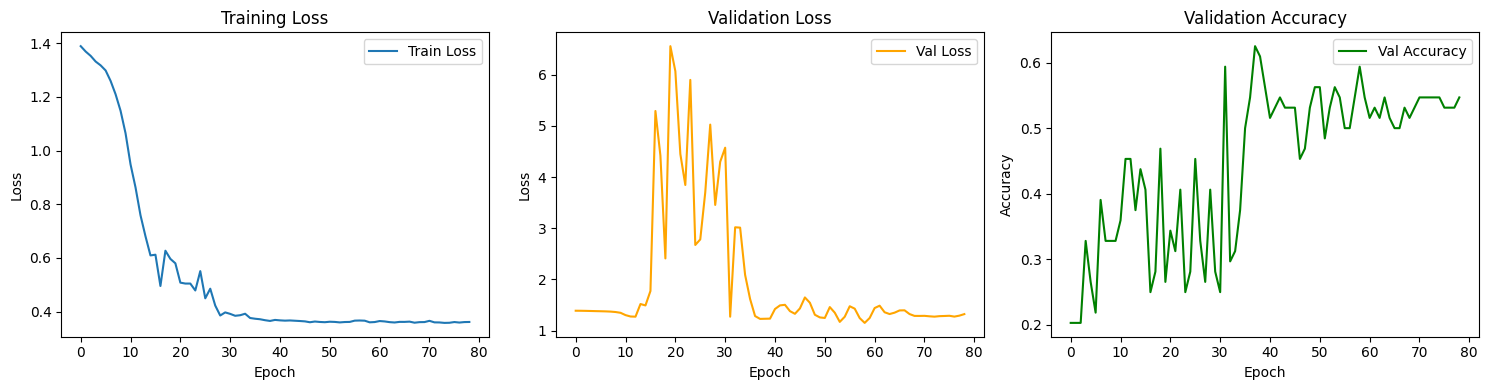


 Final Test Results 
Accuracy: 0.6875

Confusion Matrix:
[[11  2  6  0]
 [ 0 17  1  0]
 [ 1  1 14  0]
 [ 0  7  2  2]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.9167    0.5789    0.7097        19
        Calm     0.6296    0.9444    0.7556        18
       Happy     0.6087    0.8750    0.7179        16
         Sad     1.0000    0.1818    0.3077        11

    accuracy                         0.6875        64
   macro avg     0.7887    0.6451    0.6227        64
weighted avg     0.7733    0.6875    0.6556        64



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import random

# Fix random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# CNN Model
class CNN2D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2D, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.15)
        self.fc2 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.relu(self.bn5(self.conv5(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                            steps_per_epoch=len(train_loader),
                                            epochs=num_epochs, pct_start=0.3)

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float("inf")
    best_model_state, patience_counter = None, 0
    early_stop_patience = 20

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Validation
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{num_epochs}, "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

        #Early stopping on val loss
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (val loss not improving)")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return train_losses, val_losses, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_predictions, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy, all_predictions, all_labels

# Main Execution
if __name__ == "__main__":

    image_root = "/content/drive/MyDrive/EmotionSpeech_Images"
    if not os.path.exists(image_root):
        print("Error: Spectrogram images not found!")
        exit()

    transform = transforms.Compose([
        transforms.Resize((150, 50)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(image_root, "Train"),
        transform=transform
    )
    test_dataset = datasets.ImageFolder(
        root=os.path.join(image_root, "Test"),
        transform=transform
    )

    # Split test → validation + final test
    val_size = len(test_dataset) // 2
    test_size = len(test_dataset) - val_size
    val_dataset, final_test_dataset = random_split(
        test_dataset, [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print("Dataset classes:", train_dataset.classes)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Final Test samples: {len(final_test_dataset)}")

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                             generator=torch.Generator().manual_seed(42))
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

    # Train model
    model = CNN2D(num_classes=4)
    train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, num_epochs=100)

    # Plot curves
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label="Val Loss", color="orange")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accs, label="Val Accuracy", color="green")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final test evaluation
    accuracy, predictions, true_labels = evaluate_model(model, test_loader)

    print(f"\n Final Test Results ")
    print(f"Accuracy: {accuracy:.4f}")

    emotions = ["Angry", "Calm", "Happy", "Sad"]
    cm = confusion_matrix(true_labels, predictions)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=emotions, digits=4, zero_division=0))


### with augmentation (baseline CNN trained from scratch)

Dataset classes: ['Angry', 'Calm', 'Happy', 'Sad']
Training samples: 128
Validation samples: 64
Final Test samples: 64
Epoch 0/200, Train Loss: 1.3914, Val Loss: 1.3895, Val Acc: 0.2031
Epoch 5/200, Train Loss: 1.3681, Val Loss: 1.3887, Val Acc: 0.2031
Epoch 10/200, Train Loss: 1.3386, Val Loss: 1.3845, Val Acc: 0.2656
Epoch 15/200, Train Loss: 1.3447, Val Loss: 1.3727, Val Acc: 0.2500
Epoch 20/200, Train Loss: 1.3245, Val Loss: 1.3572, Val Acc: 0.3750
Epoch 25/200, Train Loss: 1.2761, Val Loss: 1.3410, Val Acc: 0.4531
Epoch 30/200, Train Loss: 1.2210, Val Loss: 1.3243, Val Acc: 0.4688
Epoch 35/200, Train Loss: 1.2039, Val Loss: 1.3212, Val Acc: 0.4062
Epoch 40/200, Train Loss: 1.1495, Val Loss: 1.3139, Val Acc: 0.3750
Epoch 45/200, Train Loss: 1.2620, Val Loss: 1.3097, Val Acc: 0.3125
Epoch 50/200, Train Loss: 1.1763, Val Loss: 1.3015, Val Acc: 0.4844
Epoch 55/200, Train Loss: 1.1250, Val Loss: 1.3145, Val Acc: 0.3750
Epoch 60/200, Train Loss: 1.0894, Val Loss: 1.2987, Val Acc: 0.4375

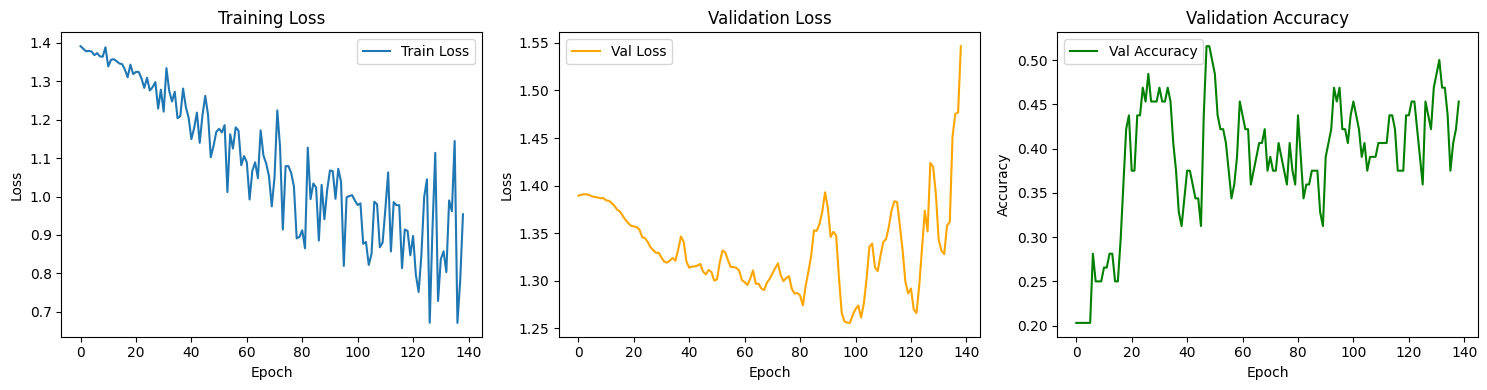


Final Test Results (unseen data) 
Accuracy: 0.4844

Confusion Matrix:
[[ 8  1 10  0]
 [ 0 11  7  0]
 [ 3  1 12  0]
 [ 0  1 10  0]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.7273    0.4211    0.5333        19
        Calm     0.7857    0.6111    0.6875        18
       Happy     0.3077    0.7500    0.4364        16
         Sad     0.0000    0.0000    0.0000        11

    accuracy                         0.4844        64
   macro avg     0.4552    0.4455    0.4143        64
weighted avg     0.5138    0.4844    0.4608        64



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# CNN Model
class CNN2D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2D, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.15)
        self.fc2 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.relu(self.bn5(self.conv5(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x


# Spectrogram Augmentation
def apply_spectrogram_augmentation(inputs, device):
    batch_size, channels, height, width = inputs.shape
    inputs_unnorm = inputs * 0.5 + 0.5  # back to [0,1]
    augmented_batch = []

    for i in range(batch_size):
        spectrogram = inputs_unnorm[i, 0].clone()
        aug_choice = torch.rand(1).item()

        if aug_choice < 0.25:  # Frequency masking
            num_masks = torch.randint(1, 3, (1,)).item()
            for _ in range(num_masks):
                mask_width = torch.randint(4, min(12, height // 6), (1,)).item()
                mask_start = torch.randint(0, height - mask_width, (1,)).item()
                spectrogram[mask_start:mask_start + mask_width, :] = 0.0

        elif aug_choice < 0.5:  # Time masking
            num_masks = torch.randint(1, 3, (1,)).item()
            for _ in range(num_masks):
                mask_width = torch.randint(4, min(15, width // 5), (1,)).item()
                mask_start = torch.randint(0, width - mask_width, (1,)).item()
                spectrogram[:, mask_start:mask_start + mask_width] = 0.0

        elif aug_choice < 0.7:  # Spectral noise
            noise = torch.randn_like(spectrogram) * 0.04
            spectrogram = torch.clamp(spectrogram + noise, 0, 1)

        elif aug_choice < 0.9:  # Amplitude scaling
            scale = 0.8 + torch.rand(1).item() * 0.4
            spectrogram = torch.clamp(spectrogram * scale, 0, 1)

        else:  # Time shift
            shift = torch.randint(-width // 20, width // 20, (1,)).item()
            spectrogram = torch.roll(spectrogram, shifts=shift, dims=1)

        augmented_batch.append(spectrogram.unsqueeze(0))

    augmented_inputs = torch.stack(augmented_batch)
    augmented_inputs = (augmented_inputs - 0.5) / 0.5
    return augmented_inputs.to(device)

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Training with Early Stopping (val loss)
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, use_spectrogram_aug=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs, pct_start=0.3
    )

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float("inf")
    best_model_state, patience_counter = None, 0
    early_stop_patience =40

    for epoch in range(num_epochs):
        #Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if use_spectrogram_aug and torch.rand(1) > 0.3:
                inputs = apply_spectrogram_augmentation(inputs, device)

            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Validation
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{num_epochs}, "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

        #Early stopping on validation loss
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (val loss not improving)")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return train_losses, val_losses, val_accuracies

# Final Evaluation
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_predictions, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy, all_predictions, all_labels

# Main
if __name__ == "__main__":

    image_root = "/content/drive/MyDrive/EmotionSpeech_Images"
    if not os.path.exists(image_root):
        print("Error: Spectrogram images not found!")
        exit()

    transform = transforms.Compose([
        transforms.Resize((150, 50)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(image_root, "Train"),
        transform=transform
    )
    test_dataset = datasets.ImageFolder(
        root=os.path.join(image_root, "Test"),
        transform=transform
    )

    # Split test into validation + final test
    val_size = len(test_dataset) // 2
    test_size = len(test_dataset) - val_size
    val_dataset, final_test_dataset = random_split(
        test_dataset, [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print("Dataset classes:", train_dataset.classes)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Final Test samples: {len(final_test_dataset)}")

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                             generator=torch.Generator().manual_seed(42))
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

    # Train model
    model = CNN2D(num_classes=4)
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader,
        num_epochs=200, use_spectrogram_aug=True
    )

    # Plot curves
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label="Val Loss", color="orange")
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies, label="Val Accuracy", color="green")
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final evaluation on held-out test set
    accuracy, predictions, true_labels = evaluate_model(model, test_loader)

    print(f"\nFinal Test Results (unseen data) ")
    print(f"Accuracy: {accuracy:.4f}")

    emotions = ['Angry', 'Calm', 'Happy', 'Sad']
    cm = confusion_matrix(true_labels, predictions)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=emotions, digits=4, zero_division=0))

### With augmentation + transfer learning (EfficientNet-B0)

Dataset classes: ['Angry', 'Calm', 'Happy', 'Sad']
Training samples: 128
Validation samples: 64
Final Test samples: 64

 Phase 1: Training top layers
Epoch 0/200, Train Loss: 1.3997, Val Loss: 1.3855, Val Acc: 0.2188
Epoch 5/200, Train Loss: 1.2749, Val Loss: 1.3623, Val Acc: 0.3281
Epoch 10/200, Train Loss: 1.2350, Val Loss: 1.3578, Val Acc: 0.3750
Epoch 15/200, Train Loss: 1.0102, Val Loss: 1.2275, Val Acc: 0.4844
Epoch 20/200, Train Loss: 0.9824, Val Loss: 1.1113, Val Acc: 0.5469
Epoch 25/200, Train Loss: 0.9756, Val Loss: 1.1270, Val Acc: 0.5469
Epoch 30/200, Train Loss: 0.9395, Val Loss: 1.2048, Val Acc: 0.4688
Epoch 35/200, Train Loss: 0.9355, Val Loss: 1.3262, Val Acc: 0.5000
Epoch 40/200, Train Loss: 1.0834, Val Loss: 1.3189, Val Acc: 0.5156
Epoch 45/200, Train Loss: 1.0452, Val Loss: 1.2655, Val Acc: 0.5156
Epoch 50/200, Train Loss: 0.6442, Val Loss: 1.2844, Val Acc: 0.5000
Epoch 55/200, Train Loss: 0.8447, Val Loss: 1.3021, Val Acc: 0.5312
Epoch 60/200, Train Loss: 0.8030, Va

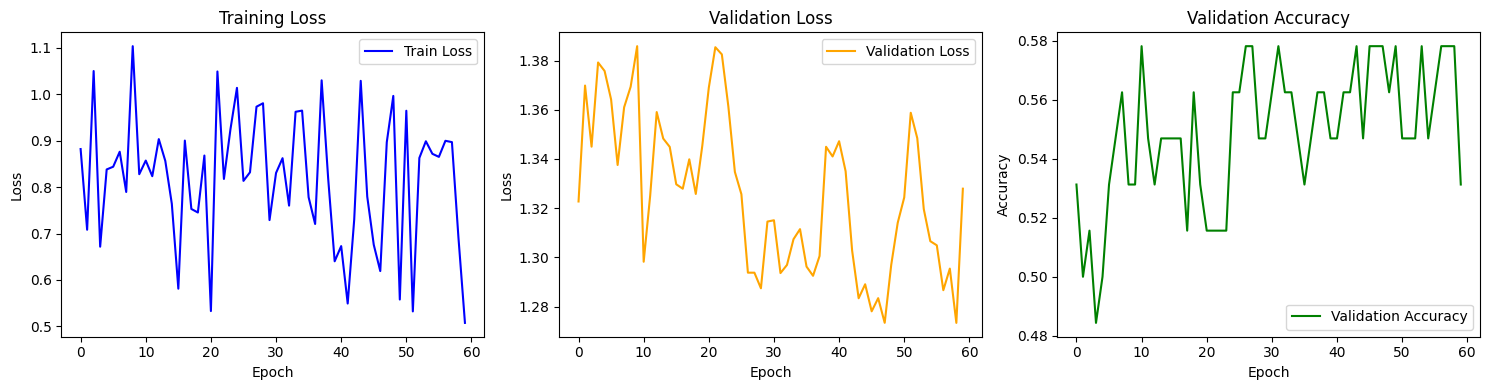


Final Test Accuracy: 0.7500

Confusion Matrix:
 [[14  2  3  0]
 [ 0 16  0  2]
 [ 0  1 15  0]
 [ 0  7  1  3]]

Classification Report:
               precision    recall  f1-score   support

       Angry     1.0000    0.7368    0.8485        19
        Calm     0.6154    0.8889    0.7273        18
       Happy     0.7895    0.9375    0.8571        16
         Sad     0.6000    0.2727    0.3750        11

    accuracy                         0.7500        64
   macro avg     0.7512    0.7090    0.7020        64
weighted avg     0.7704    0.7500    0.7352        64



In [ ]:
# EfficientNet-B0 Emotion Recognition with Mixup + Fine-tuning

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from sklearn.metrics import confusion_matrix, classification_report
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Model Definition
class EfficientNetEmotion(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(EfficientNetEmotion, self).__init__()
        self.model = efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        # Modify input for grayscale spectrograms
        self.model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
        # Replace classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Spectrogram Augmentation
def apply_spectrogram_augmentation(inputs, device):
    batch_size, channels, height, width = inputs.shape
    inputs_unnorm = inputs * 0.5 + 0.5  # back to [0,1]
    augmented_batch = []

    for i in range(batch_size):
        spectrogram = inputs_unnorm[i, 0].clone()
        aug_choice = torch.rand(1).item()

        if aug_choice < 0.25:  # Frequency masking
            num_masks = torch.randint(1, 3, (1,)).item()
            for _ in range(num_masks):
                mask_width = torch.randint(4, min(12, height // 6), (1,)).item()
                mask_start = torch.randint(0, height - mask_width, (1,)).item()
                spectrogram[mask_start:mask_start + mask_width, :] = 0.0

        elif aug_choice < 0.5:  # Time masking
            num_masks = torch.randint(1, 3, (1,)).item()
            for _ in range(num_masks):
                mask_width = torch.randint(4, min(15, width // 5), (1,)).item()
                mask_start = torch.randint(0, width - mask_width, (1,)).item()
                spectrogram[:, mask_start:mask_start + mask_width] = 0.0

        elif aug_choice < 0.7:  # Spectral noise
            noise = torch.randn_like(spectrogram) * 0.04
            spectrogram = torch.clamp(spectrogram + noise, 0, 1)

        elif aug_choice < 0.9:  # Amplitude scaling
            scale = 0.8 + torch.rand(1).item() * 0.4
            spectrogram = torch.clamp(spectrogram * scale, 0, 1)

        else:  # Time shift
            shift = torch.randint(-width // 20, width // 20, (1,)).item()
            spectrogram = torch.roll(spectrogram, shifts=shift, dims=1)

        augmented_batch.append(spectrogram.unsqueeze(0))

    augmented_inputs = torch.stack(augmented_batch)
    augmented_inputs = (augmented_inputs - 0.5) / 0.5
    return augmented_inputs.to(device)

# Mixup Regularization
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=200, lr=0.0003, use_spectrogram_aug=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Slight weighting for underrepresented classes (Sad class)
    class_weights = torch.tensor([0.9, 1.0, 1.0, 1.2]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float("inf")
    best_model_state, patience_counter = None, 0
    early_stop_patience = 40

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if use_spectrogram_aug and torch.rand(1) > 0.3:
                inputs = apply_spectrogram_augmentation(inputs, device)

            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Validation
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        scheduler.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (val loss not improving)")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return train_losses, val_losses, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy, all_predictions, all_labels


# Main
if __name__ == "__main__":
    image_root = "/content/drive/MyDrive/EmotionSpeech_Images"

    transform = transforms.Compose([
        transforms.Resize((150, 50)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.ImageFolder(os.path.join(image_root, "Train"), transform=transform)
    test_dataset = datasets.ImageFolder(os.path.join(image_root, "Test"), transform=transform)
    val_size = len(test_dataset) // 2
    test_size = len(test_dataset) - val_size
    val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size],
                                                   generator=torch.Generator().manual_seed(42))

    print("Dataset classes:", train_dataset.classes)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Final Test samples: {len(final_test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

    # Phase 1: Train last 3 blocks + classifier
    model = EfficientNetEmotion(num_classes=4, pretrained=True)
    for name, param in model.named_parameters():
        if not ("features.5" in name or "features.6" in name or "features.7" in name or "classifier" in name):
            param.requires_grad = False

    print("\n Phase 1: Training top layers")
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader,
        num_epochs=200, lr=0.0003, use_spectrogram_aug=True
    )

    # Phase 2: Fine-tune entire model
    # Phase 2 runs only 60 epochs with a lower LR to gently fine-tune all layer and avoid over-adjusting pretrained filters after Phase 1 adaptation.
    print("\n Phase 2: Fine-tuning all layers with low LR")
    for param in model.parameters():
        param.requires_grad = True

    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader,
        num_epochs=60, lr=0.00005, use_spectrogram_aug=True
    )


# Plot Phase 2 training curves
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label="Validation Loss", color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies, label="Validation Accuracy", color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Final evaluation
    accuracy, predictions, true_labels = evaluate_model(model, test_loader)
    print(f"\nFinal Test Accuracy: {accuracy:.4f}")
    emotions = ['Angry', 'Calm', 'Happy', 'Sad']
    cm = confusion_matrix(true_labels, predictions)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n",
          classification_report(true_labels, predictions, target_names=emotions, digits=4, zero_division=0))
